In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Necessary imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from tqdm import tqdm

In [7]:
from tensorflow import keras
model = keras.models.load_model('/content/BEST_model.keras')

In [8]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/5.Brain tumor project using CNN/brain tumor dataset/Testing',
    target_size=(224, 224), # Ensure target size matches model input
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb')


Found 720 images belonging to 4 classes.


In [9]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 224s 18s/step - accuracy: 0.9580 - loss: 0.1400 - precision: 0.9627 - recall: 0.9541
Test Accuracy: 0.9528
Test Loss: 0.1453
Test Precision: 0.9579
Test Recall: 0.9472


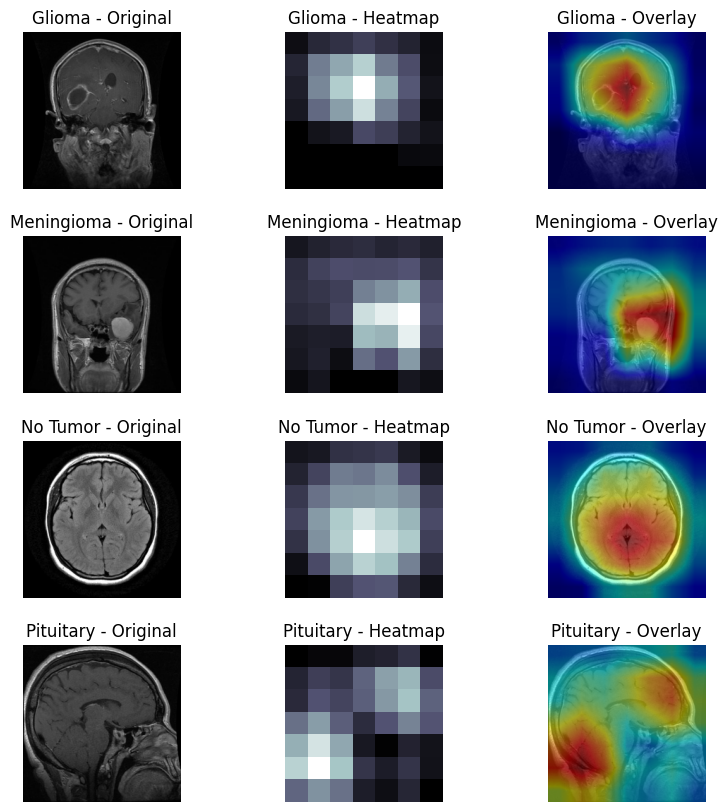

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2

# =============================
# 📌 Image paths and labels
# =============================
img_paths = [
    "/content/drive/MyDrive/5.Brain tumor project using CNN/brain tumor dataset/Testing/glioma/Te-gl_0060.jpg",
    "/content/drive/MyDrive/5.Brain tumor project using CNN/brain tumor dataset/Testing/meningioma/Te-me_0160.jpg",
    "/content/drive/MyDrive/5.Brain tumor project using CNN/brain tumor dataset/Testing/notumor/Te-no_0379.jpg",
    "/content/drive/MyDrive/5.Brain tumor project using CNN/brain tumor dataset/Testing/pituitary/Te-pi_0252.jpg"
]

img_names = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

# =============================
# 📌 Grad-CAM function
# =============================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# =============================
# 📌 Select the convolutional layer
# =============================
last_conv_layer_name = "conv5_block16_concat"

# =============================
# 📌 Create the figure (4 rows × 3 columns)
# =============================
fig, axes = plt.subplots(len(img_paths), 3, figsize=(10, 10))  # 3 columns: Original, Heatmap, Overlay
plt.subplots_adjust(wspace=0.05, hspace=0.3)  # Small space between images, slightly larger between rows

for i, (img_path, img_name) in enumerate(zip(img_paths, img_names)):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Original image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))

    # Row 1: Original
    axes[i, 0].imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(f"{img_name} - Original", fontsize=12)
    axes[i, 0].axis('off')

    # Row 2: Heatmap
    axes[i, 1].imshow(heatmap, cmap='bone')
    axes[i, 1].set_title(f"{img_name} - Heatmap", fontsize=12)
    axes[i, 1].axis('off')

    # Row 3: Overlay
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_color, 0.5, img_cv, 0.5, 0)

    axes[i, 2].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title(f"{img_name} - Overlay", fontsize=12)
    axes[i, 2].axis('off')

plt.show()
